In [1]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from sklearn.model_selection import train_test_split

from generate_design_matrix import DesignMatrixGenerator, ExpFilter
from get_rat_data import *
from multiclass_logistic_regression import MultiClassLogisticRegression
from sigma_tau_search_experiment_reward import SigmaTauSearchExperimentReward
from method_validation import plot_kernel_validation

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

In [10]:
df = get_rat_viol_data().query("training_stage > 2")

returning dataset for all animals


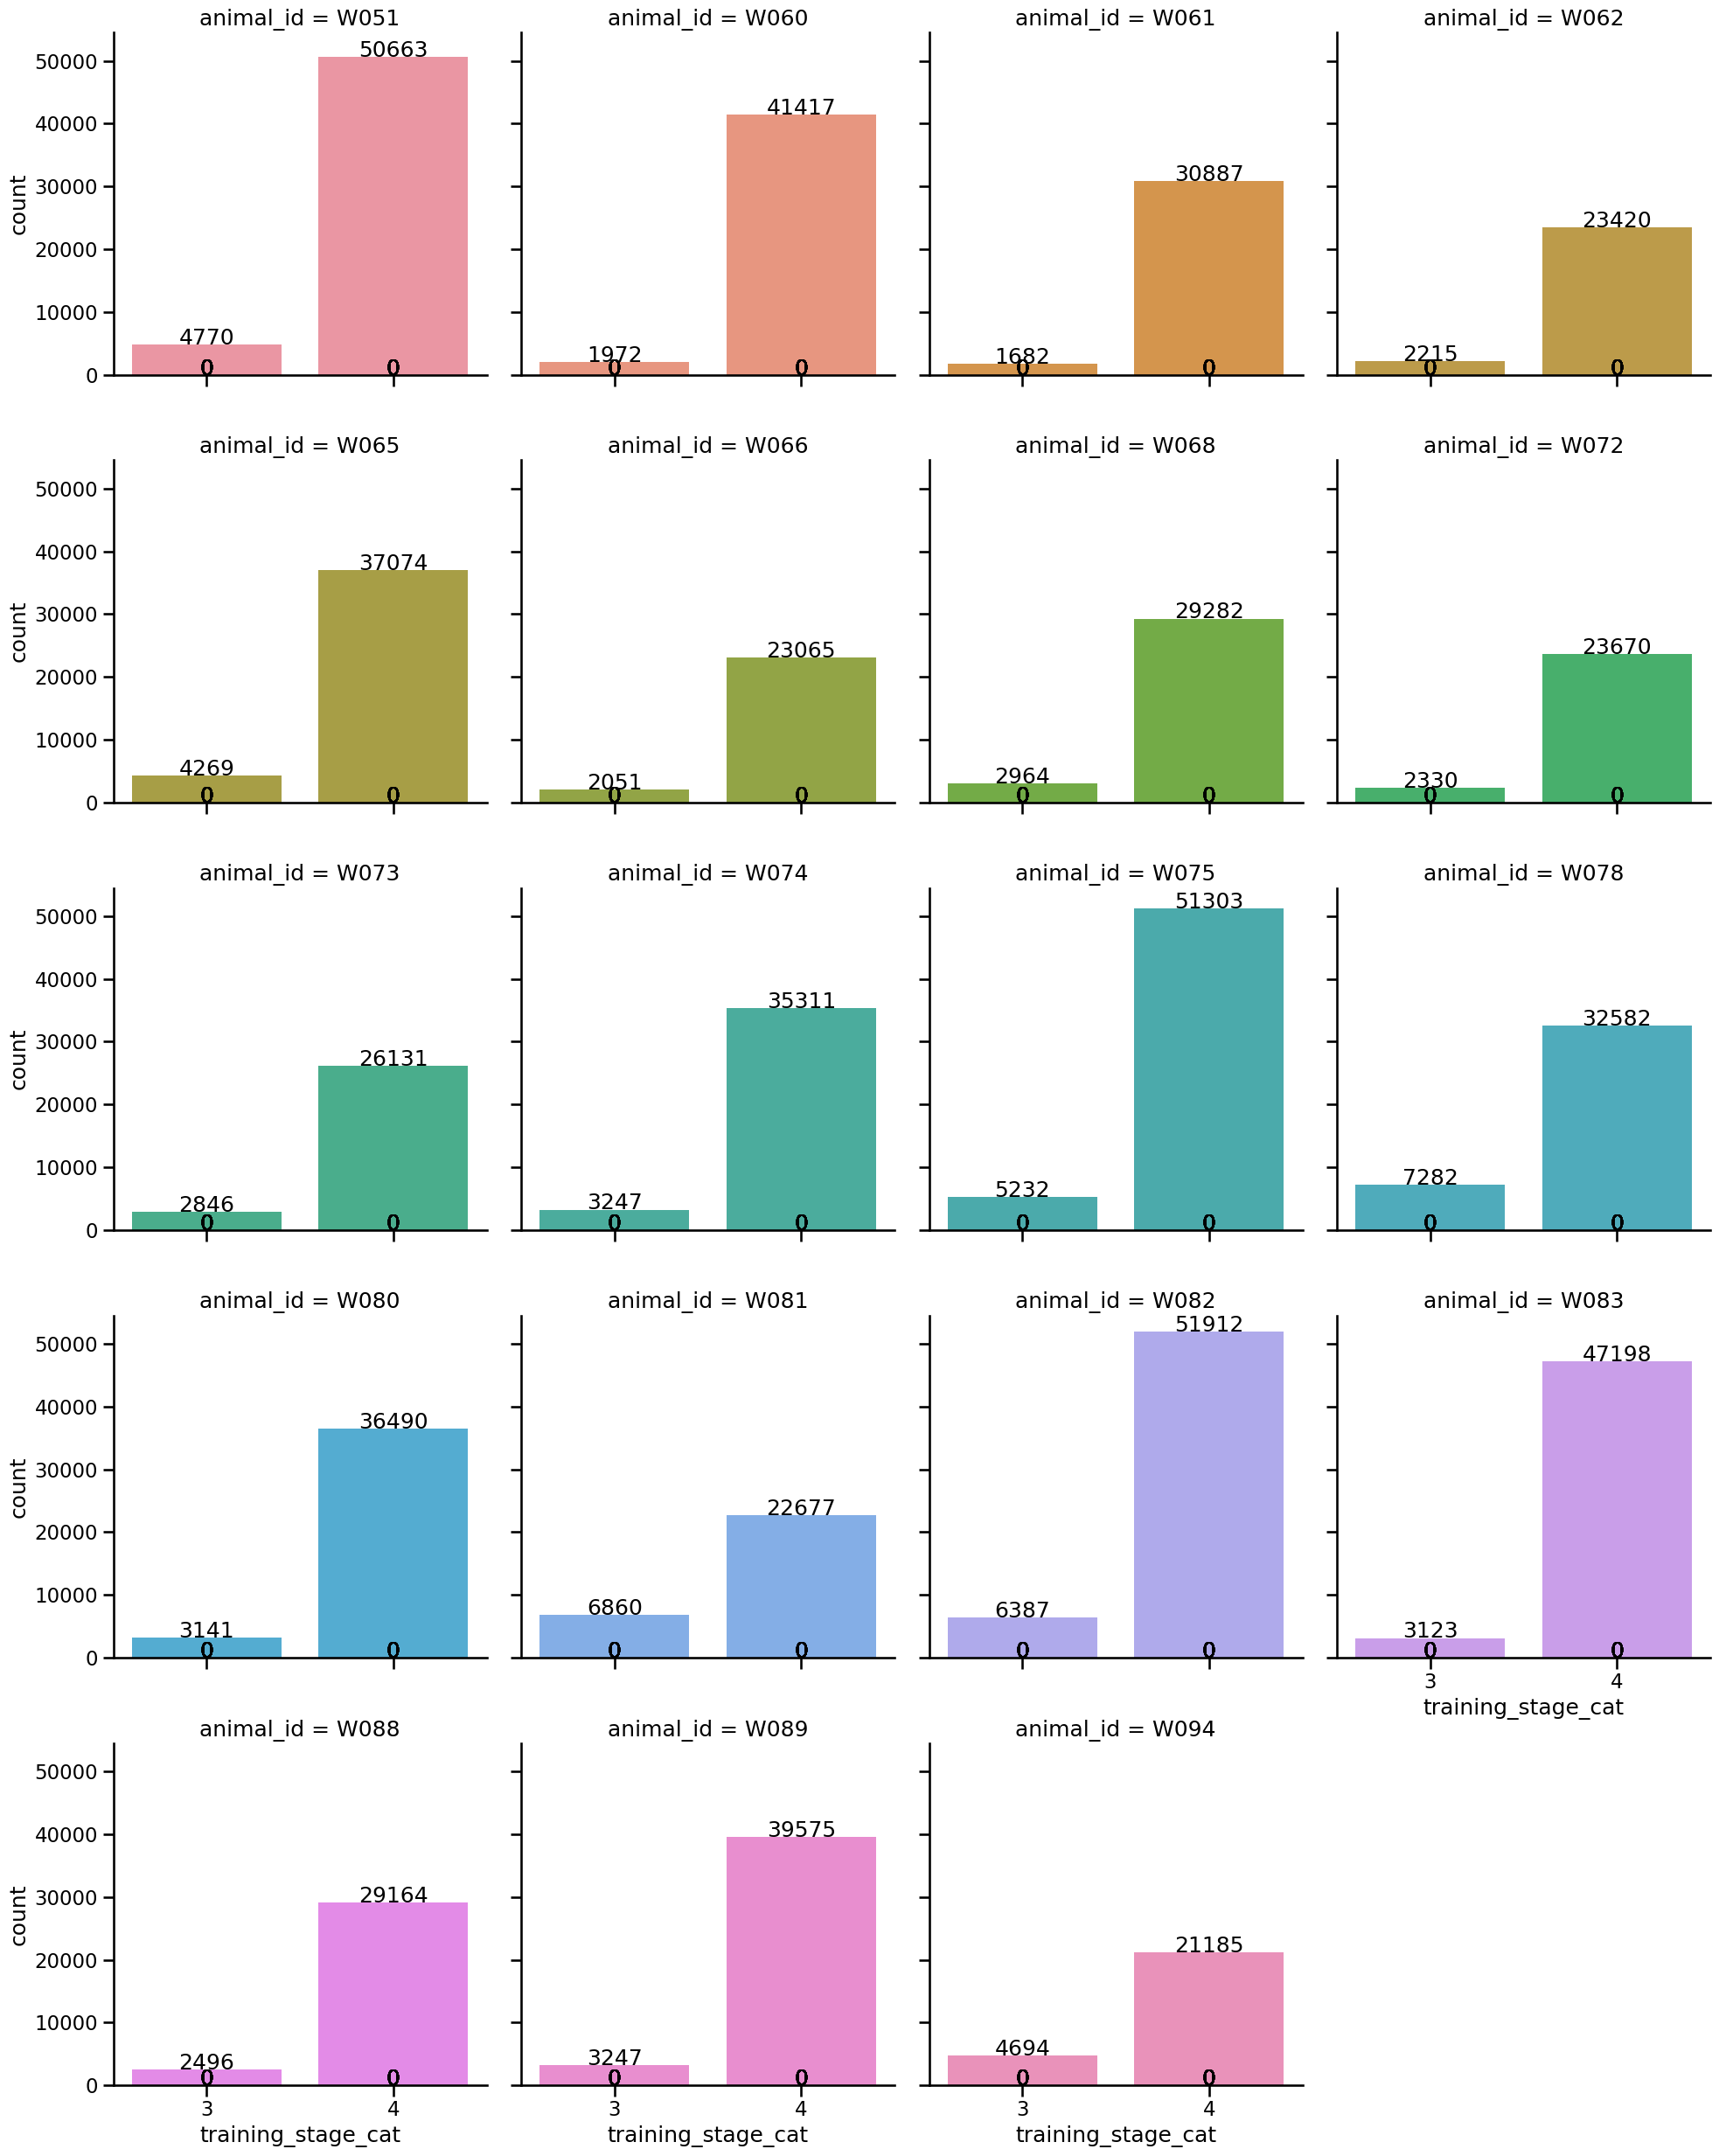

In [12]:
g = sns.catplot(
    x="training_stage_cat",
    col="animal_id",
    col_wrap=4,
    hue="animal_id",
    data=df,
    kind="count",
    dodge=False,
    sharey=True,
)

for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,
            p.get_height() + 5,  # Adjust the vertical position of the label
            f"{int(p.get_height())}",  # Display count as an integer
            ha="center",  # Center the text horizontally
        )

In [18]:
rolling_mean

,animal_id,session,training_stage,hit
0,W051,31,3,NaN
1,W051,32,3,NaN
2,W051,33,3,NaN
3,W051,34,3,NaN
4,W051,35,3,NaN
...,...,...,...,...
3039,W094,195,4,0.620159
3040,W094,196,4,0.616753
3041,W094,197,4,0.624040
3042,W094,198,4,0.624808


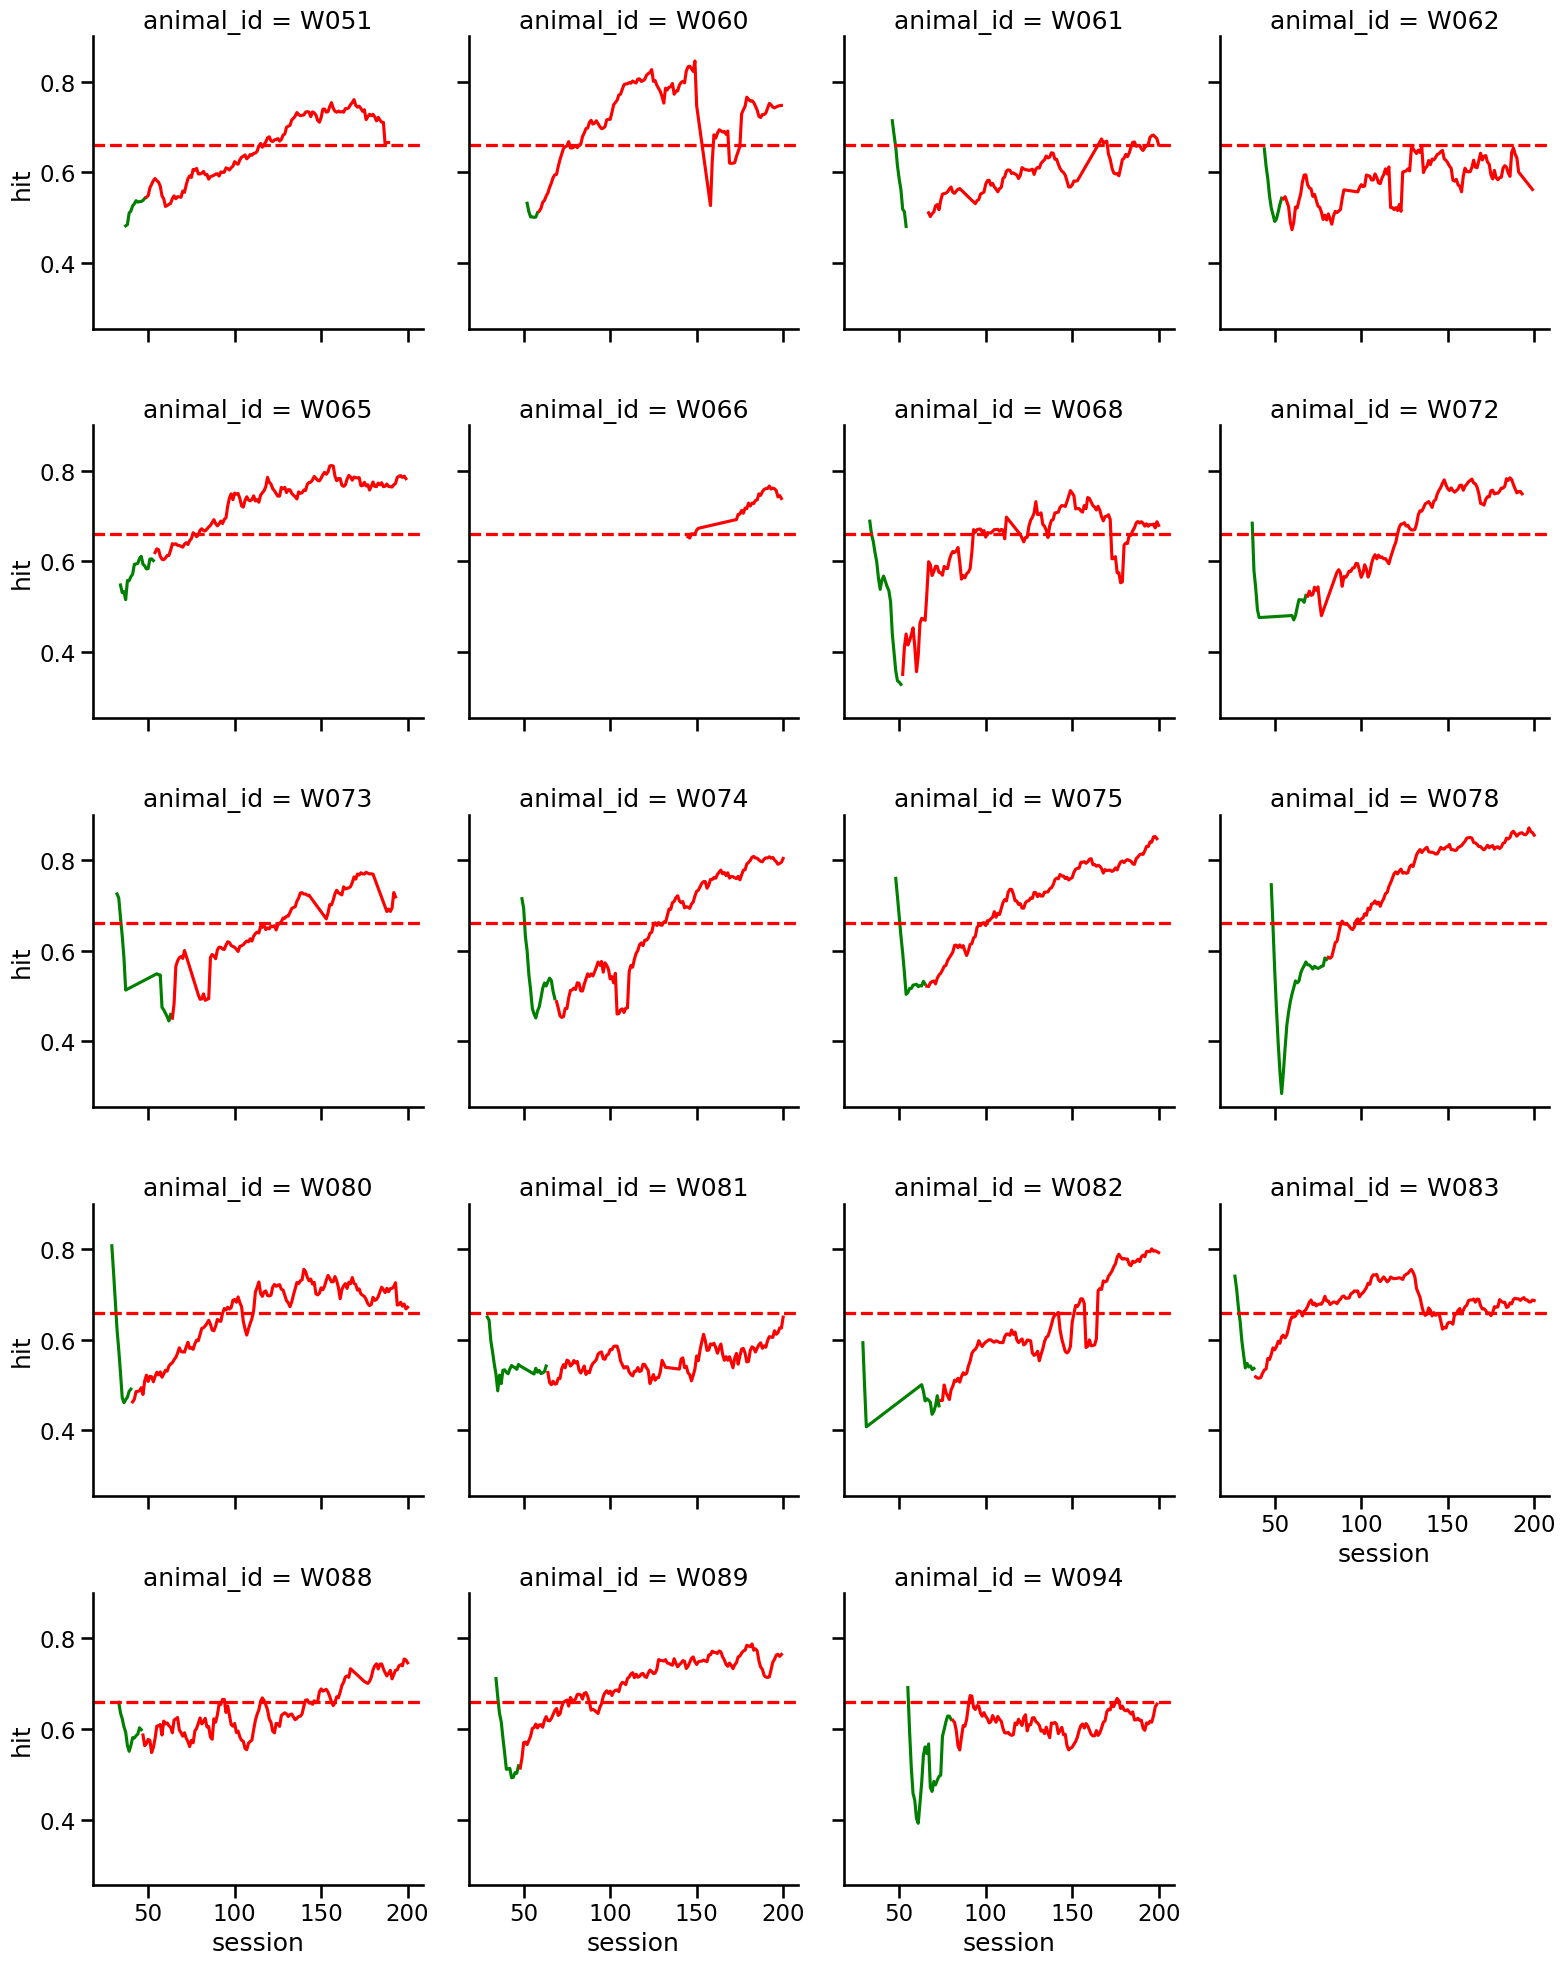

In [25]:
# Groupby subject and session, and calculate the mean hit for each subject-session combination
grouped_df = df.groupby(["animal_id", "session", "training_stage"]).hit.mean()

# Calculate the rolling mean with a window of 14 sessions for each subject
rolling_mean = grouped_df.rolling(window=7).mean().reset_index()

# # Create the facet grid plot
g = sns.FacetGrid(
    data=rolling_mean,
    col="animal_id",
    col_wrap=4,
    hue="training_stage",
    height=4,
    palette=["green", "red"],
)
g.map(sns.lineplot, "session", "hit")
g.map(plt.axhline, y=0.66, color="red", linestyle="--")

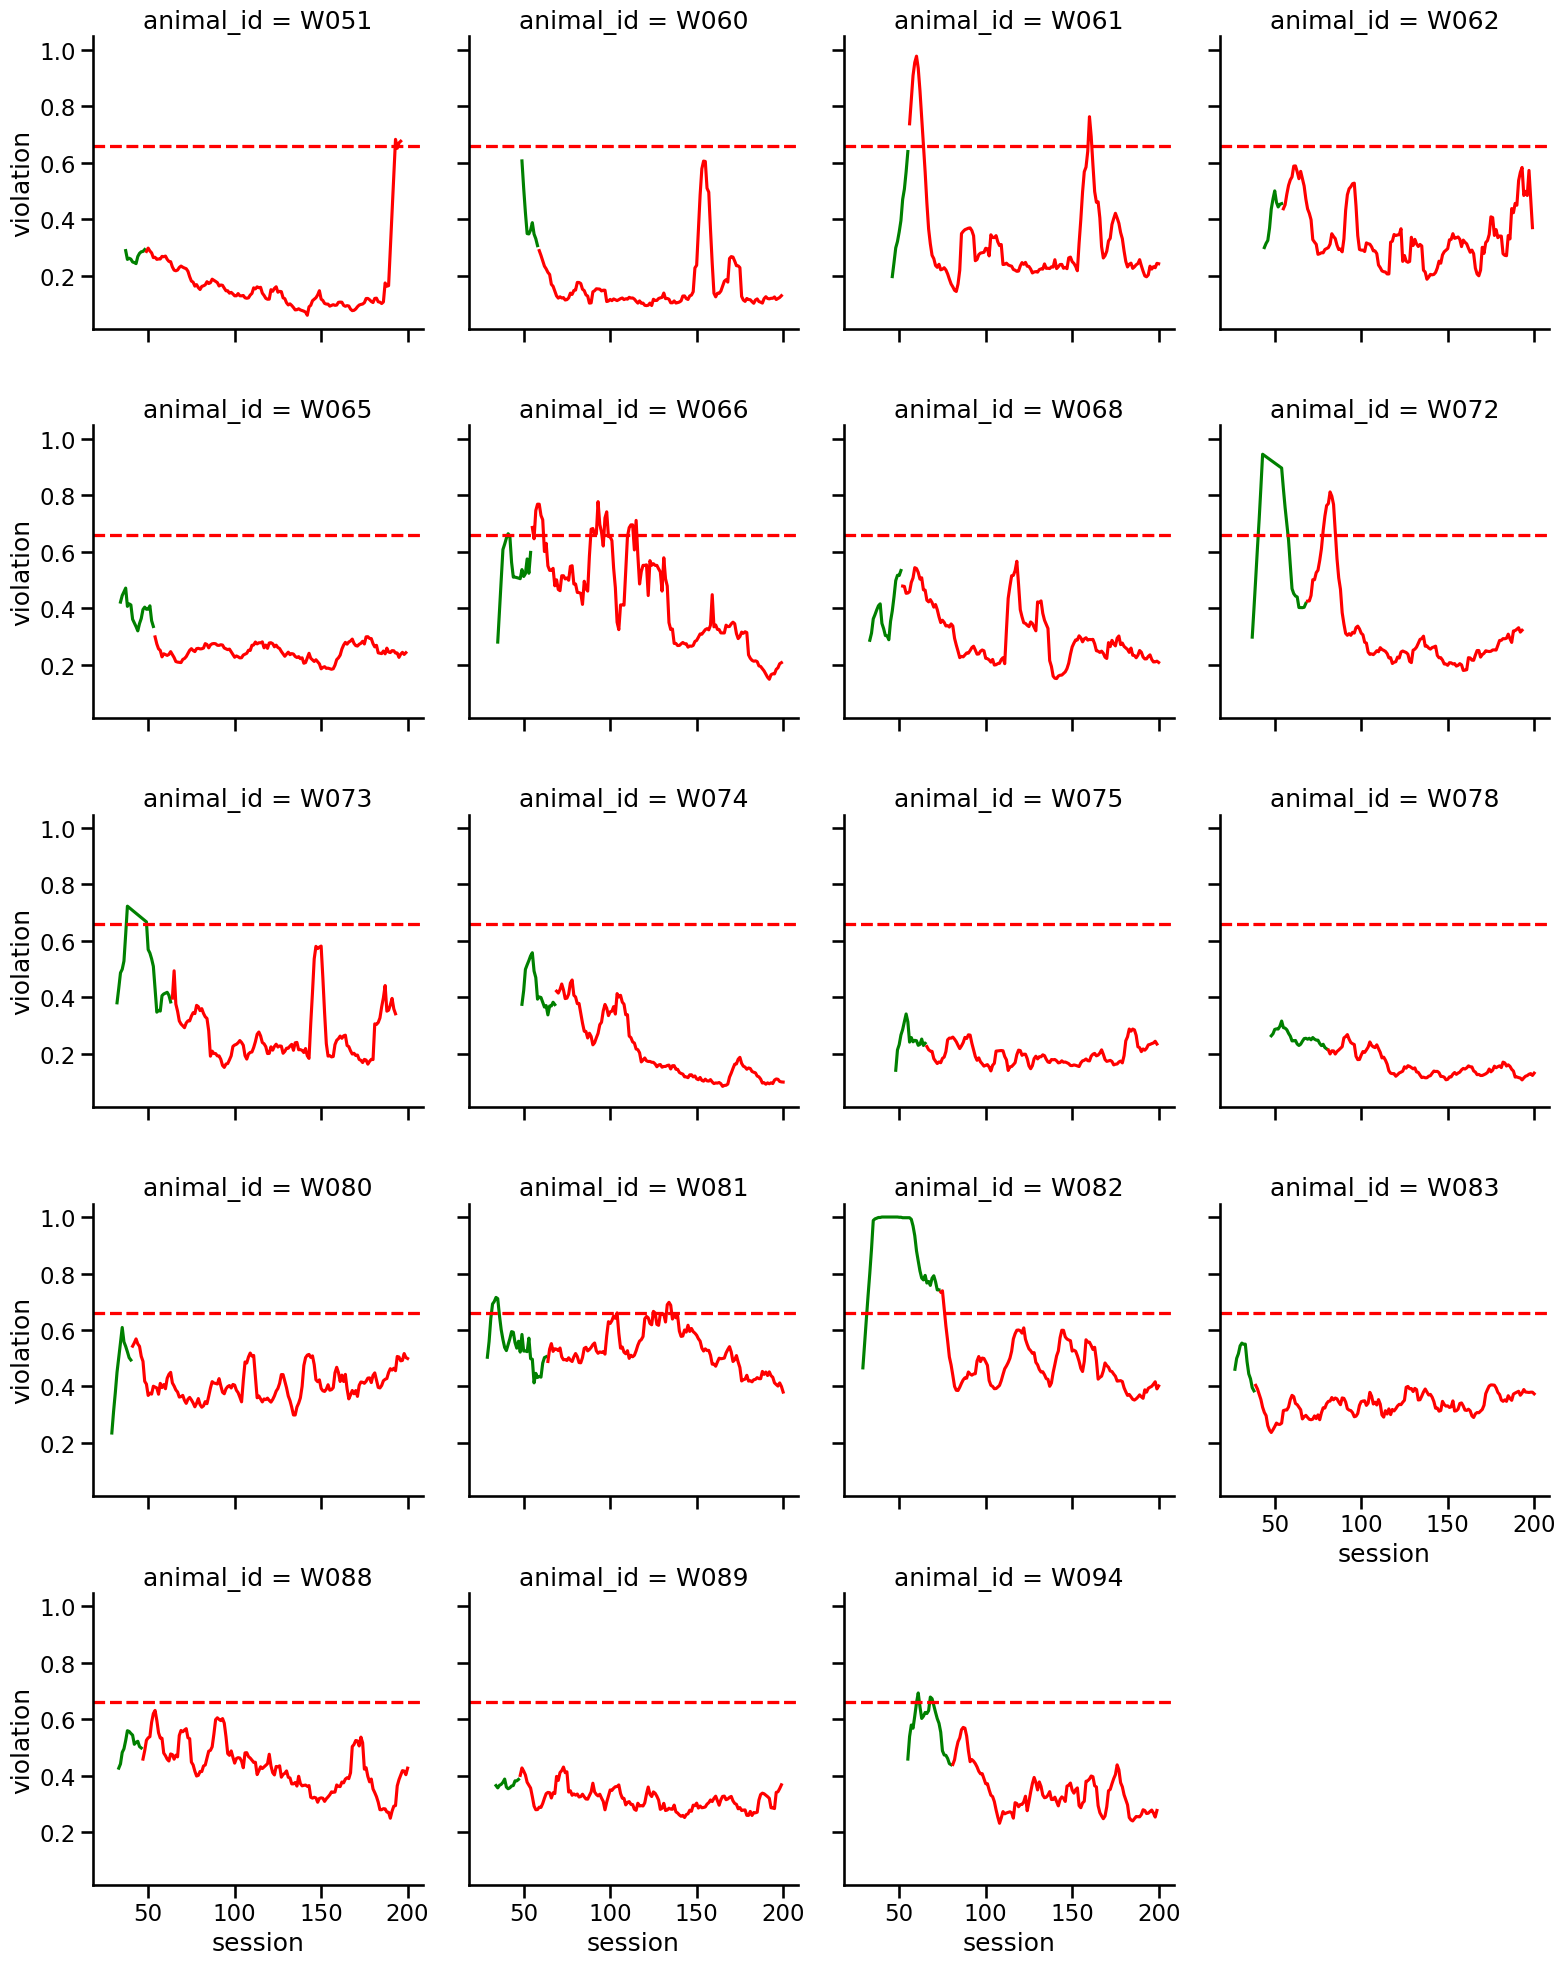

In [113]:
# Groupby subject and session, and calculate the mean hit for each subject-session combination
grouped_df = df.groupby(["animal_id", "session", "training_stage"]).violation.mean()

# Calculate the rolling mean with a window of 14 sessions for each subject
rolling_mean = grouped_df.rolling(window=7).mean().reset_index()

# # Create the facet grid plot
g = sns.FacetGrid(
    data=rolling_mean,
    col="animal_id",
    col_wrap=4,
    hue="training_stage",
    height=4,
    palette=["green", "red"],
)
g.map(sns.lineplot, "session", "violation")
g.map(plt.axhline, y=0.66, color="red", linestyle="--")

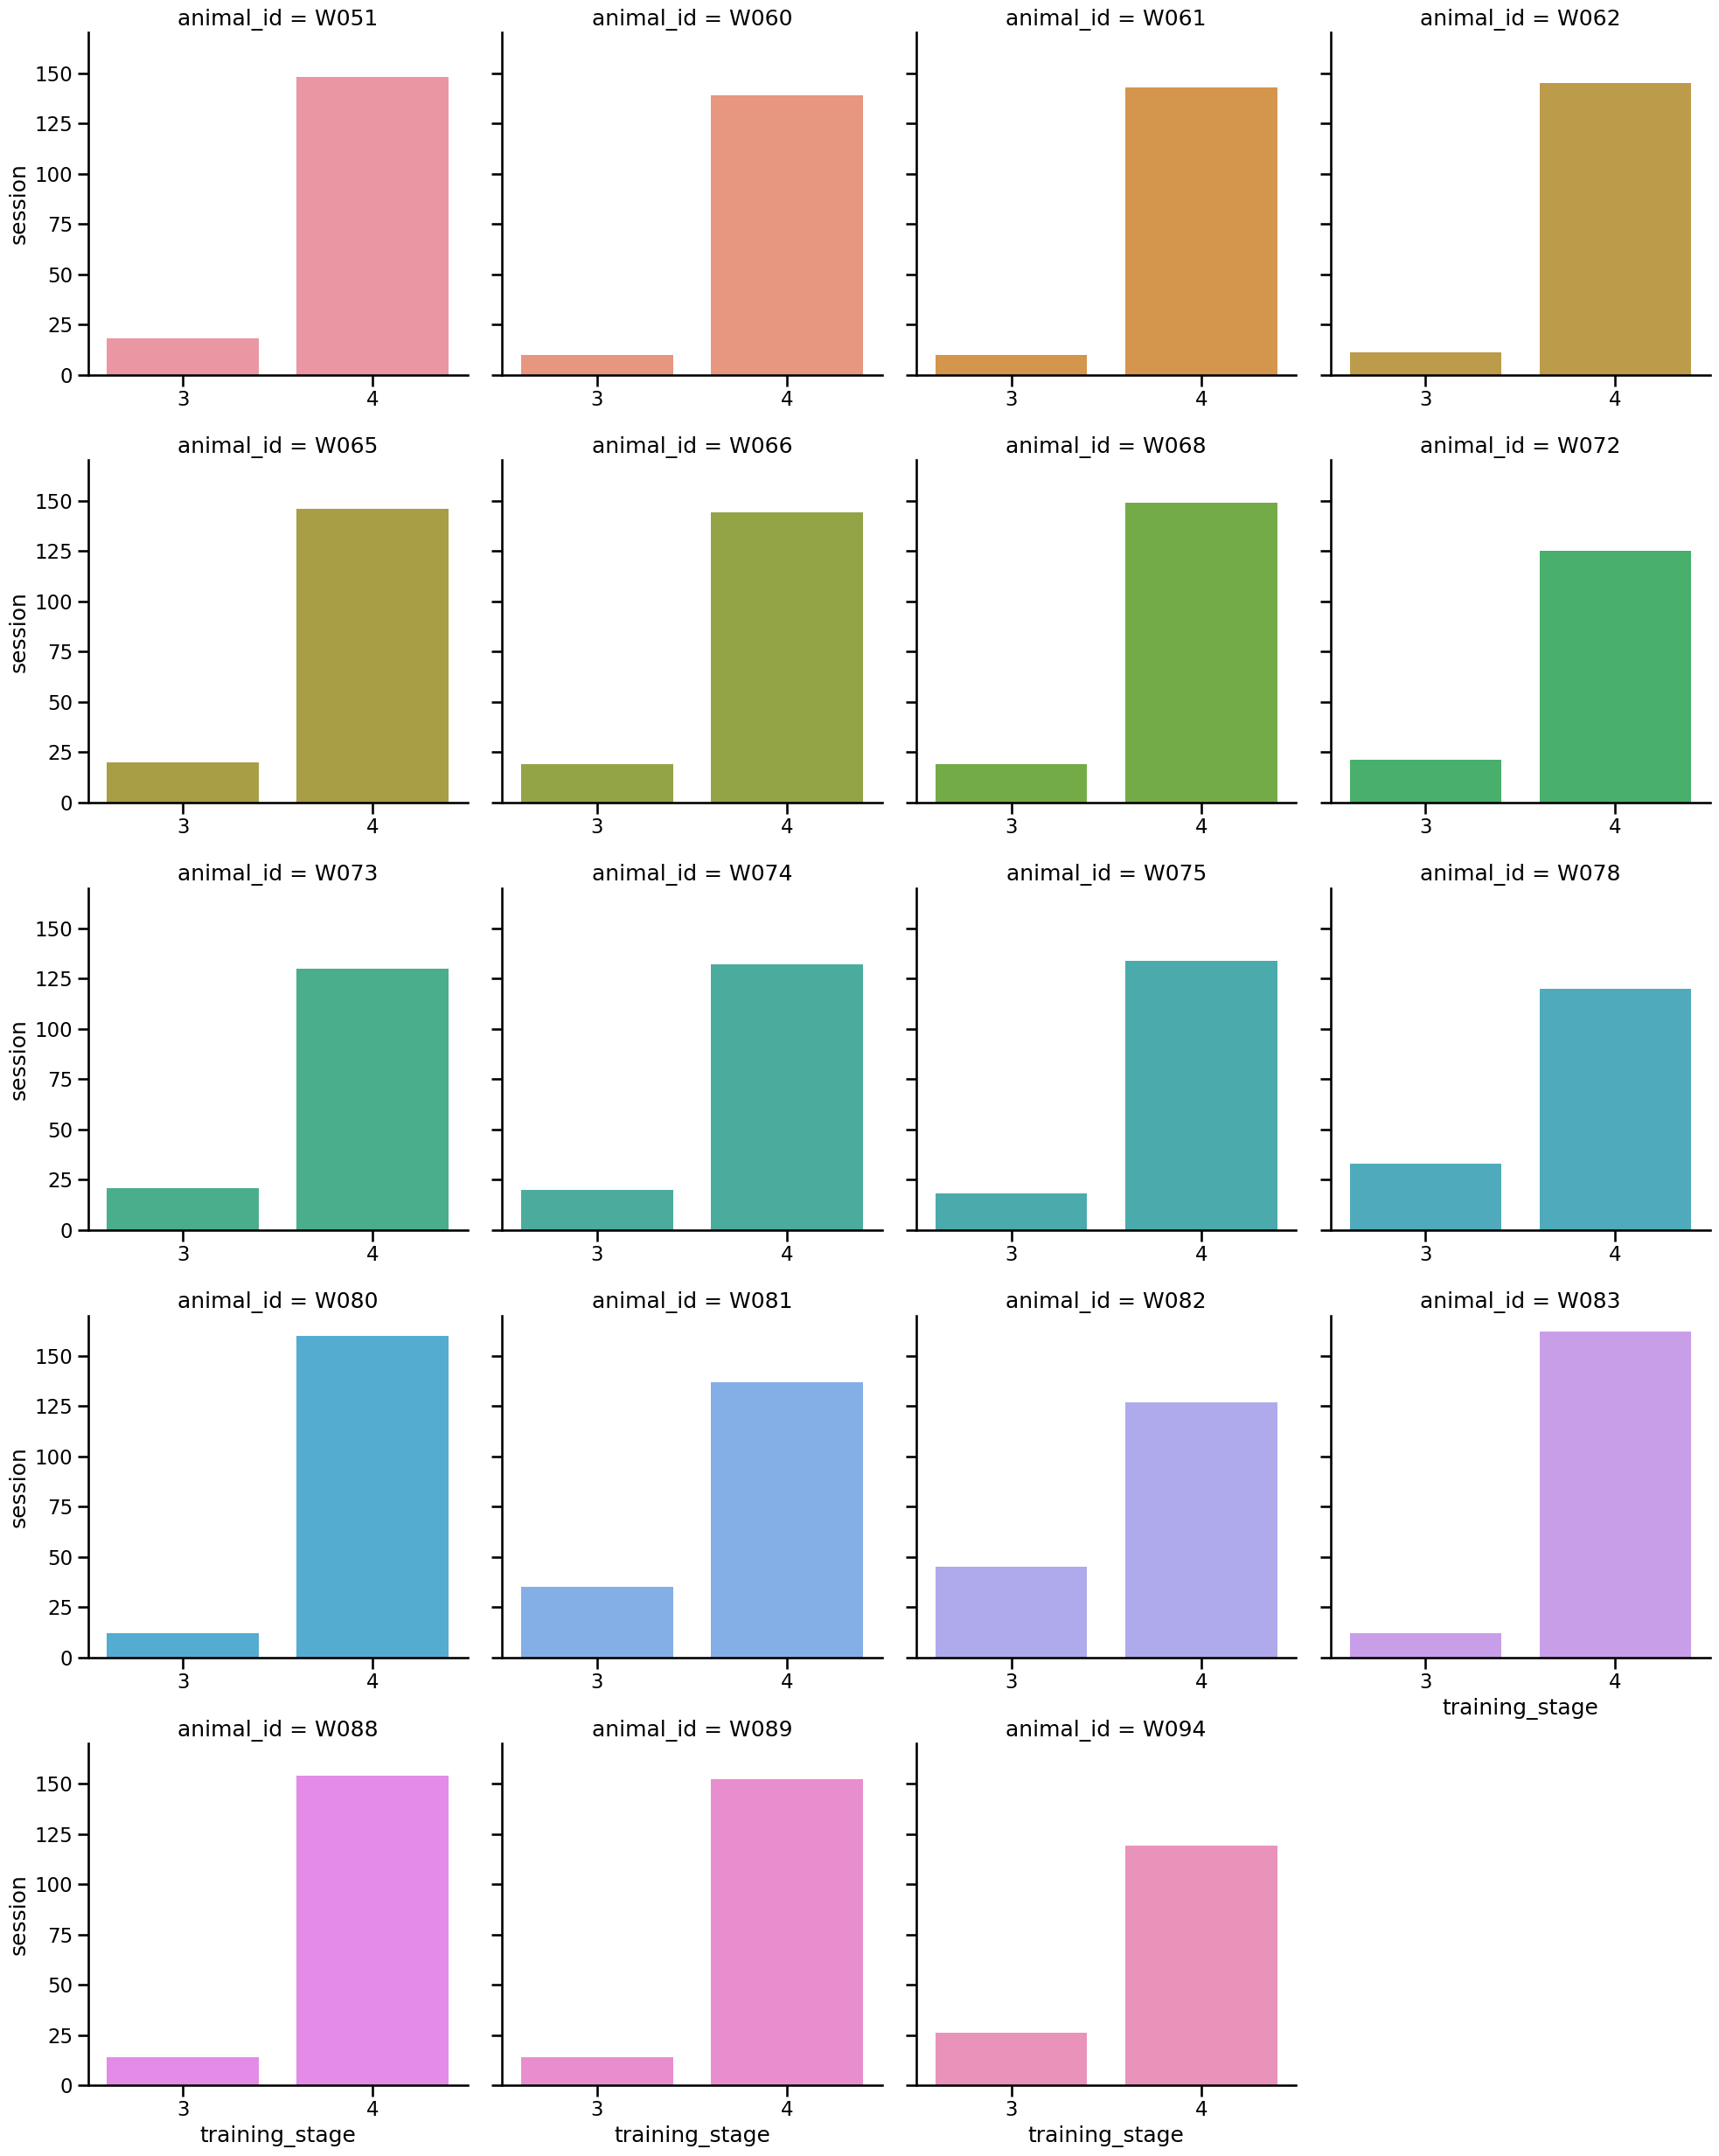

In [31]:
session_counts = (
    df.groupby(["animal_id", "training_stage"]).session.nunique().reset_index()
)

g = sns.catplot(
    x="training_stage",
    y="session",
    col="animal_id",
    col_wrap=4,
    hue="animal_id",
    data=session_counts,
    kind="bar",
    dodge=False,
    sharey=True,
    sharex=False,
)

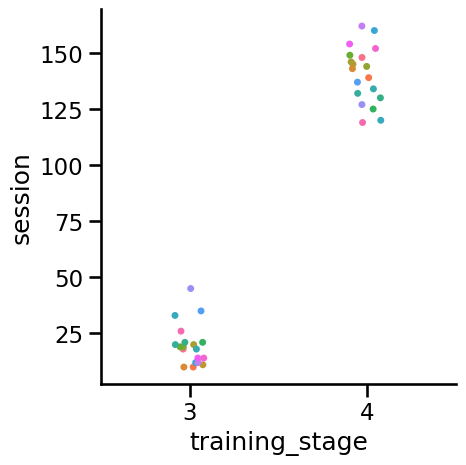

In [40]:
sns.catplot(
    data=session_counts,
    x="training_stage",
    y="session",
    hue="animal_id",
    legend=False,
)

possible ideas:
* sa/sb plot for stage 3 versus stage 4 for each animal

* add in a prev_rewarded and prev_delayed rewarded regressor and fit stage 3 and 4 together
    * could also fit stage 3 on it's own? but hit rate in stage 3 is not highly correlated with any variables.



In [115]:
df.sort_values(by=["animal_id", "session"], ascending=[True, False], inplace=True)

grouped = df.groupby("animal_id").head(30)
result = grouped.groupby("animal_id")["hit"].mean().reset_index()

In [128]:
result["violation_stage_3"] = result["animal_id"].map(
    df.query("training_stage == 3").groupby("animal_id")["violation"].mean()
)

In [129]:
result["n_days_stage_3"] = result["animal_id"].map(
    session_counts.query("training_stage == 3").groupby("animal_id")["session"].max()
)

(0.0, 1.0)

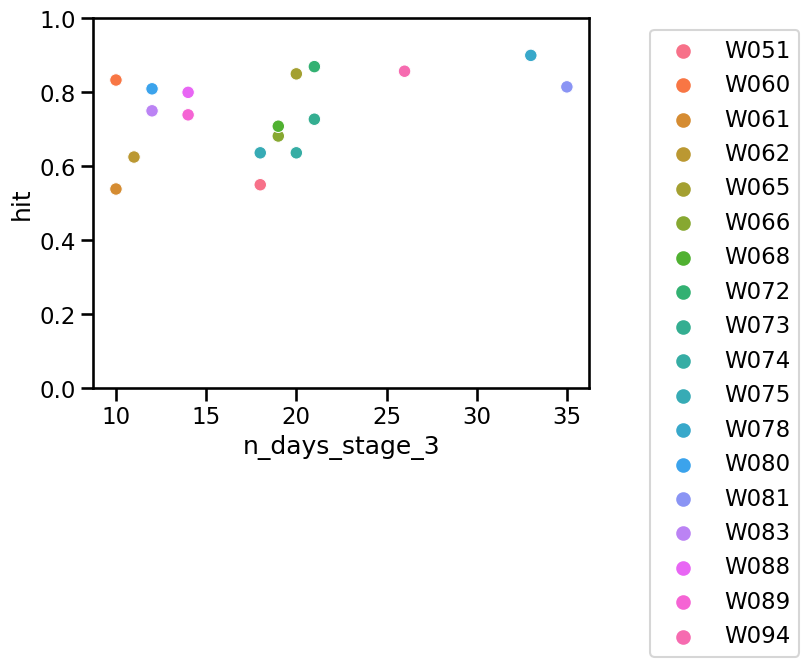

In [131]:
sns.scatterplot(
    data=result.query("animal_id != 'W082'"),
    x="n_days_stage_3",
    y="hit",
    hue="animal_id",
)
plt.legend(bbox_to_anchor=(1.10, 1))

plt.ylim(0, 1)

(0.0, 1.0)

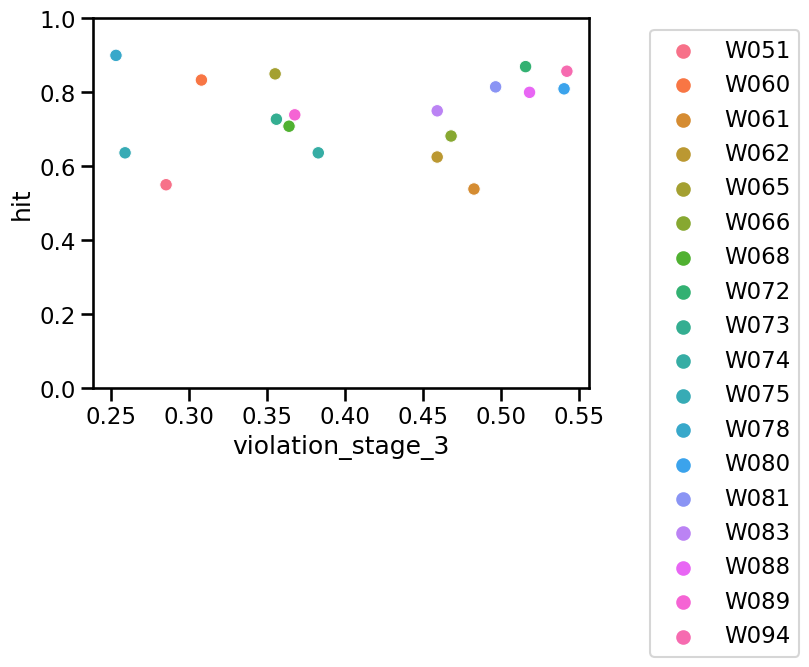

In [134]:
sns.scatterplot(
    data=result.query("animal_id != 'W082'"),
    x="violation_stage_3",
    y="hit",
    hue="animal_id",
)
plt.legend(bbox_to_anchor=(1.10, 1))

plt.ylim(0, 1)

In [91]:
w082 = df.query("animal_id == 'W082' and training_stage == 3")

# Calculate value counts (number of trials) for each session
value_counts = w082["session"].value_counts().reset_index()
value_counts.columns = ["session", "num_trials"]

# Calculate the hit rate (mean of 'hit' column) for each session
hit_rate = w082.groupby("session")["hit"].mean().reset_index()
viol_rate = w082.groupby("session")["violation"].mean().reset_index()

w082result = value_counts.merge(hit_rate, on="session")
w082result = w082result.merge(viol_rate, on="session")

w082result.fillna(0, inplace=True)

<Axes: xlabel='session', ylabel='num_trials'>

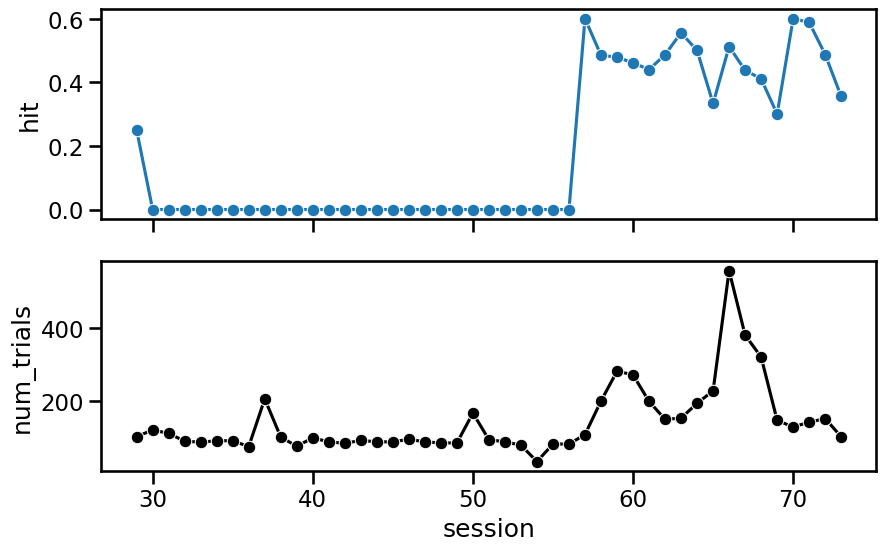

In [99]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

sns.lineplot(data=w082result, x="session", y="hit", marker="o", ax=ax[0])
sns.lineplot(data=w082result, x="session", y="num_trials", color="k", marker="o", ax=ax[1])

Although this animal was in stage 3 for a long time, it violation for most of it, so I don't think all of these days should count. Longer term, counting the number of sessions in stage 3 where the hit rate is not NaN would be a better metric.

### Was_delayed_reward regressor

In [242]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


class DesignMatrixGeneratorFeatureComparison:
    def __init__(self, feature_mode, verbose=True):
        self.verbose = verbose
        self.feature_mode = feature_mode

    @staticmethod
    def normalize_column(col):
        return (col - col.mean()) / col.std()

    def generate_design_matrix(
        self, df, return_labels=True, drop_session_column=False
    ):
        """
        Function to generate design matrix given a dataframe and feature mode
        with violations tracked. In this case "base" means using the
        same regressors as Nick Roy did in Psytrack, but adjusted to
        take into account 3 choice options (L,R, Violation).

        N = number of trials
        D = number of features
        C = number of classes, in this case 3 (L, R, Violation)

        params
        ------
        df : pd.DataFrame
            dataframe with columns `s_a` `s_b` `session`, `violation`
            `correct_side` and `choice`, likely generated by
            get_rat_viol_data()
        tau : TODO
        filter_column : TODO
            if tau is not None, which column to filter/drop
        return_label : bool (default = True)
            whether to return one-hot encoded choice labels
        drop_session_column : bool (default = False)
            whether to drop 'session' column. should be set to
            false if doing session based train/test split
            following design matrix generation

        returns
        -------
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with regressors for s_a, s_b,
            prev sound avg, correct side and choice info,
            normalized to standard normal with bias column added
        Y : np.ndarray, shape (N, C), where C = 3 if return_labels=True
            one-hot encoded choice labels for each trial as left,
            right or violation
        """
        # Initialize
        X = pd.DataFrame()
        stim_cols = ["s_a", "s_b"]
        X["session"] = df.session

        # Masks- if first trial in a session and/or previous trial
        # was a violation, "prev" variables get set to 0
        session_boundaries_mask = df["session"].diff() == 0
        X["prev_violation"] = (
            df["violation"].shift() * session_boundaries_mask
        ).fillna(0)
        prev_violation_mask = X["prev_violation"] == 0

        # # Violation Exp Filter
        if self.feature_mode != "nick":
            self.exp_filter = ExpFilter(
                tau=4, verbose=self.verbose, column="prev_violation"
            )
            self.exp_filter.apply_filter_to_dataframe(X)
        X.drop(columns=["prev_violation"], inplace=True)

        # Stimuli (s_a, s_b) get normalized
        for col in stim_cols:
            X[stim_cols] = self.normalize_column(df[stim_cols])

        # Average previous stimulus (s_a, s_b) loudness
        X["prev_sound_avg"] = df[stim_cols].shift().mean(axis=1)
        X["prev_sound_avg"] = self.normalize_column(X["prev_sound_avg"])
        X["prev_sound_avg"] *= session_boundaries_mask * prev_violation_mask

        # Prev correct side (L, R) (0, 1) -> (-1, 1),
        X["prev_correct"] = (
            df.correct_side.replace({0: -1}).astype(int).shift()
            * session_boundaries_mask
            * prev_violation_mask
        )

        # prev choice regressors (L, R, V) (0, 1, Nan) -> (-1, 1, 0),
        X["prev_choice"] = (
            df.choice.replace({0: -1}).fillna(0).astype(int).shift()
            * session_boundaries_mask
        )

        # Prev rewarded
        X["prev_rewarded"] = (df.hit.shift() * session_boundaries_mask).fillna(0)

        if self.feature_mode == "reward_filtered":
            self.exp_filter = ExpFilter(
                tau=1, verbose=self.verbose, column="prev_rewarded"
            )
            self.exp_filter.apply_filter_to_dataframe(X)
            

        if self.feature_mode == "prev_reward_inc_delay":
            # Prev delayed reward (error in stage 3)
            X["error"] = (df["hit"] == 0).astype(int)
            X["prev_error"] = (X.error.shift(1) * session_boundaries_mask).fillna(0)
            X["prev_training_stage"] = (
                df["training_stage"].shift(1) * session_boundaries_mask
            ).fillna(0)
            condition = (X["prev_training_stage"] == 3) & (X["prev_error"] == 1.0)
            X.loc[condition, "prev_delayed_rewarded"] = 1

            X.drop(columns=["error", "prev_error", "prev_training_stage"], inplace=True)
        else:
            X.drop(columns=["prev_rewarded"], inplace=True)

        X.fillna(0, inplace=True)  # remove nan from shift()
        X.insert(0, "bias", 1)  # add bias column

        if drop_session_column:
            X.drop(columns=["session"], inplace=True)

        if return_labels:
            Y = self.one_hot_encode_labels(df)
            return X, Y
        else:
            return X

    @staticmethod
    def one_hot_encode_labels(df):
        """
        Function to one-hot encode choice labels for each trial as
        left, right or violation (C = 3)

        params
        ------
        df : pd.DataFrame
            dataframe with columns `choice` likely generated by
            get_rat_viol_data()

        returns
        -------
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        """

        Y = pd.get_dummies(df["choice"], "choice", dummy_na=True).to_numpy(copy=True)
        return Y

    def get_train_test_sessions(self, df, test_size, random_state=45):
        """
        This function will return a list of sessions to use for training
        and testing respectively. To apply, see function
        see apply_session_train_test_split()


        Parameters:
        -----------
        df : pd.DataFrame
            dataframe with `sessions` column
        test_size : float
            Proportion of data to use for test set
        """
        unique_sessions = df["session"].unique()
        train_sessions, test_sessions = train_test_split(
            unique_sessions, test_size=test_size, random_state=random_state
        )

        self.train_sessions = train_sessions
        self.test_sessions = test_sessions

    def apply_session_train_test_split(self, X, Y):
        """
        train_sessions = np.array
            sessions for the
        test_values = np.array indices for the test values

        """
        # TODO add in a check to see if self._train_session
        # TODO exists, and if not, call get_train_test_sessions

        # Filter rows based on session values for X
        X_train = X[X["session"].isin(self.train_sessions)].copy()
        X_test = X[X["session"].isin(self.test_sessions)].copy()

        # Filter rows based on session values for Y
        # Assuming the index of Y corresponds to that of X
        Y_train = Y[X["session"].isin(self.train_sessions).values]
        Y_test = Y[X["session"].isin(self.test_sessions).values]

        X_train.drop(columns=["session"], inplace=True)
        X_test.drop(columns=["session"], inplace=True)

        return X_train, X_test, Y_train, Y_test


class ExpFilter:
    def __init__(self, tau, column="violation", len_factor=5, verbose=True):
        self.tau = tau
        self.column = column
        self.len_factor = len_factor
        self.verbose = verbose

    def create_kernel(self):
        """
        create an exp decay kernal with time constant tau and
        kernel length = len factor * tau
        """

        return np.array(
            [np.exp(-i / self.tau) for i in range(self.len_factor * self.tau)]
        )

    def plot_kernel(self):
        kernel = self.create_kernel()
        fig, ax = plt.subplots(figsize=(6, 4))
        plt.plot(kernel)
        plt.title(f"Exponential filter kernel | Tau: {self.tau}")
        plt.show()

    def apply_filter_to_session(self, session_df):
        """
        apply kernel to individual sessions for independent
        filtering of column history
        """
        kernel = self.create_kernel()

        # Convolve the kernel with selected column
        convolution_result = np.convolve(session_df[self.column], kernel, mode="full")[
            : len(session_df)
        ]

        session_df[f"{self.column}_exp_{self.tau}"] = convolution_result

        return session_df

    def apply_filter_to_dataframe(self, source_df, output_df=None):
        """
        Function to apply exp kernel to a column given and
        entire dataframe on a session-by-session basis
        """
        if self.tau == 0:
            return

        if output_df is None:
            output_df = source_df

        for session_id, session_data in source_df.groupby("session"):
            filtered_session = self.apply_filter_to_session(session_data.copy())
            output_df.loc[
                output_df["session"] == session_id, f"{self.column}_exp_{self.tau}"
            ] = filtered_session[f"{self.column}_exp_{self.tau}"]

            if self.verbose:
                print(
                    f"Exp filter added for session {session_id} | Column: {self.column}, Tau: {self.tau}"
                )

        # scale column by max to bound between 0 and 1
        output_df[f"{self.column}_exp_{self.tau}"] /= output_df[
            f"{self.column}_exp_{self.tau}"
        ].max()

In [246]:
from sigma_tau_search_experiment_delayed_reward import *

In [317]:
params = {
    "animals": None,
    "sigmas": [0, 0.1, 0.3, 0.5, 0.7, 1],
    "taus": [None],
    "random_state": 60,
    "test_size": 0.25,
}

experiment = SigmaTauSearchExperimentDelayedReward(params)
results = experiment.run()

returning dataset for all animals


 !!!!! evaluating animal W051 !!!!!


Optimization terminated successfully.
         Current function value: 488292.548631
         Iterations: 29
         Function evaluations: 116
         Gradient evaluations: 112
         Current function value: 488844.503991
         Iterations: 27
         Function evaluations: 81
         Gradient evaluations: 69
         Current function value: 488354.533193
         Iterations: 28
         Function evaluations: 97
         Gradient evaluations: 85
Optimization terminated successfully.
         Current function value: 488314.882311
         Iterations: 30
         Function evaluations: 67
         Gradient evaluations: 66
         Current function value: 488303.946074
         Iterations: 28
         Function evaluations: 82
         Gradient evaluations: 72
         Current function value: 488298.134084
         Iterations: 28
         Function evaluations: 45
         Gradient evaluations: 45


 !!!!! evalu

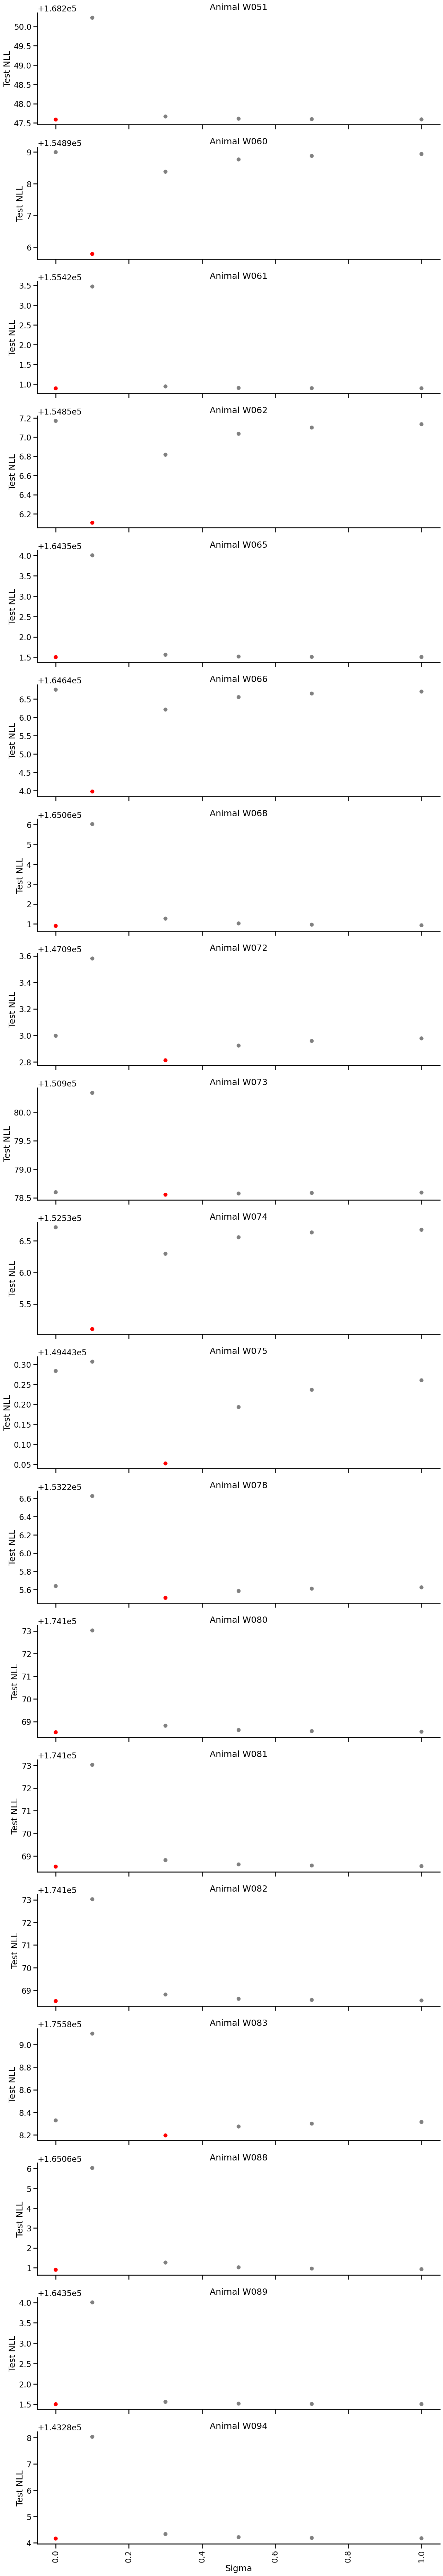

In [318]:
experiment.plot_nll_over_sigmas()

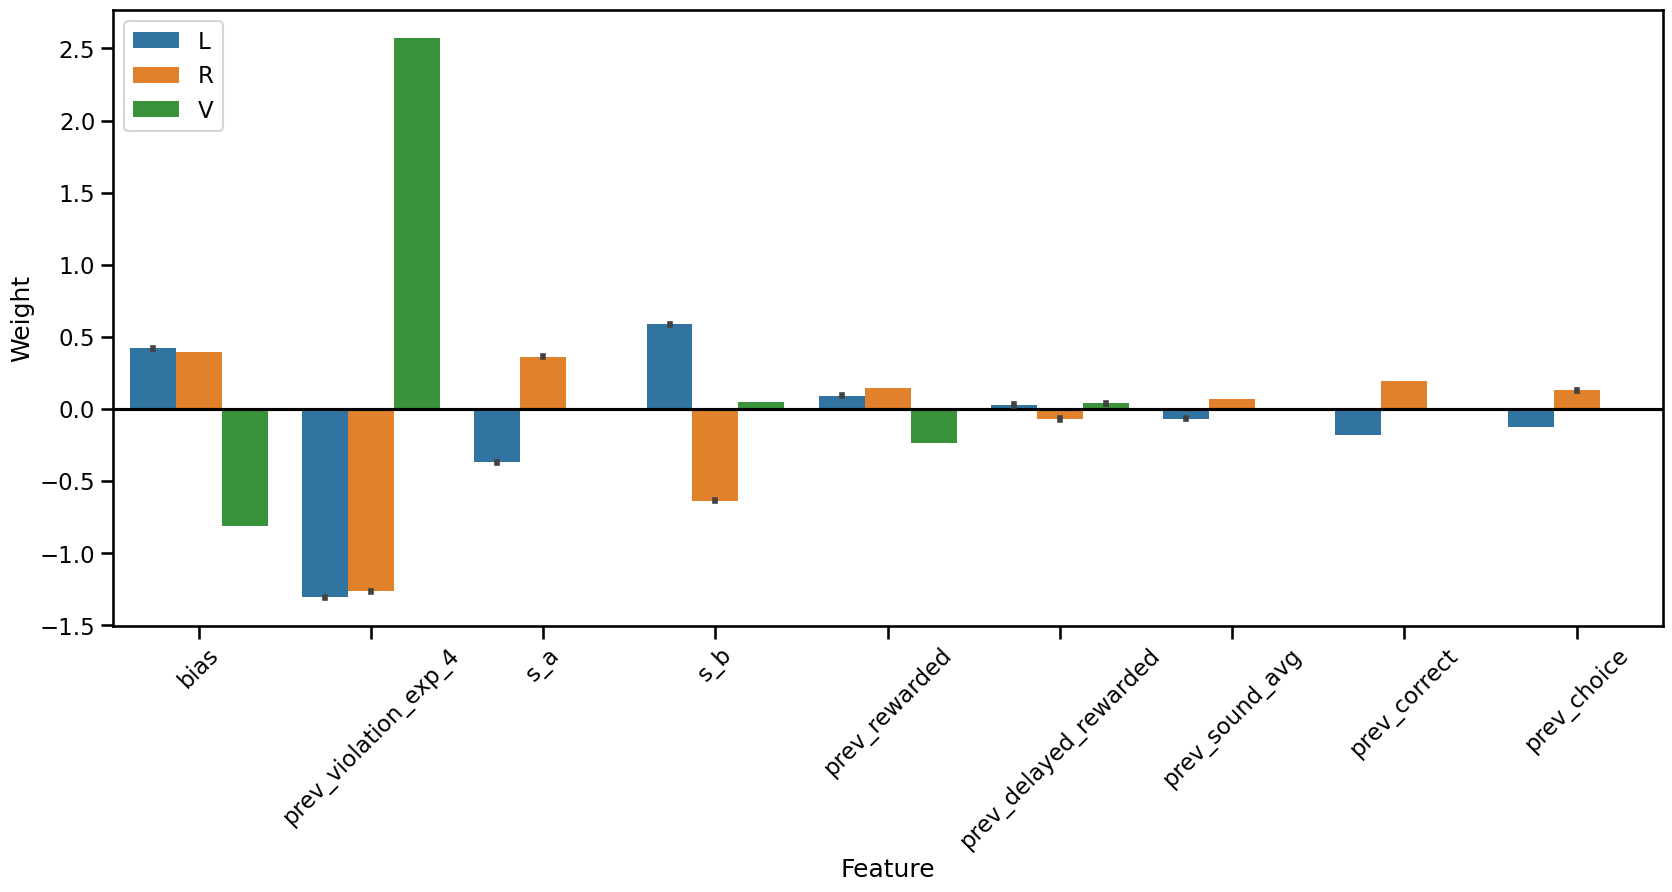

In [319]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class YourClass:
    def __init__(self, main_dataframe):
        self.main_dataframe = main_dataframe  # Assuming you store main data here

    def plot_all_class_weights(self):
        """
        Function to plot class weights for all animals and models.
        """
        # Prepare an empty DataFrame to collect data
        all_weight_data = pd.DataFrame(
            columns=["Weight", "Feature", "Class", "Animal_ID", "Model_Name"]
        )

        # Loop through all rows in the main DataFrame
        for index, row in self.main_dataframe.iterrows():
            animal_id = row["animal_id"]
            model_name = row[
                "model_name"
            ]  # Assuming MultiIndex (model_name, animal_id)
            feature_names = row["features"]
            W_fit = np.array(row["weights"])

            weight_data = self._plot_class_weights(
                feature_names, W_fit, animal_id, model_name
            )
            all_weight_data = pd.concat([all_weight_data, weight_data])

        # Plotting
        fig, ax = plt.subplots(figsize=(20, 8))
        ax.axhline(y=0, color="black")
        sns.barplot(
            x="Feature",
            y="Weight",
            hue="Class",
            # col="Animal_ID",
            # row="Model_Name",
            data=all_weight_data,
        )
        plt.xticks(rotation=45)
        plt.legend(loc="upper left")
        plt.show()

    def _plot_class_weights(self, feature_names, W_fit, animal_id, model_name):
        """
        Internal function to prepare the DataFrame for plotting weights.
        """
        D, C = W_fit.shape
        classes = ["L", "R", "V"]

        weight_data = [
            {
                "Weight": W_fit[d, c],
                "Feature": feature_names[d],
                "Class": classes[c],
                "Animal_ID": animal_id,
                "Model_Name": model_name,
            }
            for c in range(C)
            for d in range(D)
        ]
        return pd.DataFrame(weight_data)


# Example usage
main_dataframe = pd.DataFrame(
    {
        # Your main dataframe content here
    }
)
your_class_instance = YourClass(results)
your_class_instance.plot_all_class_weights()

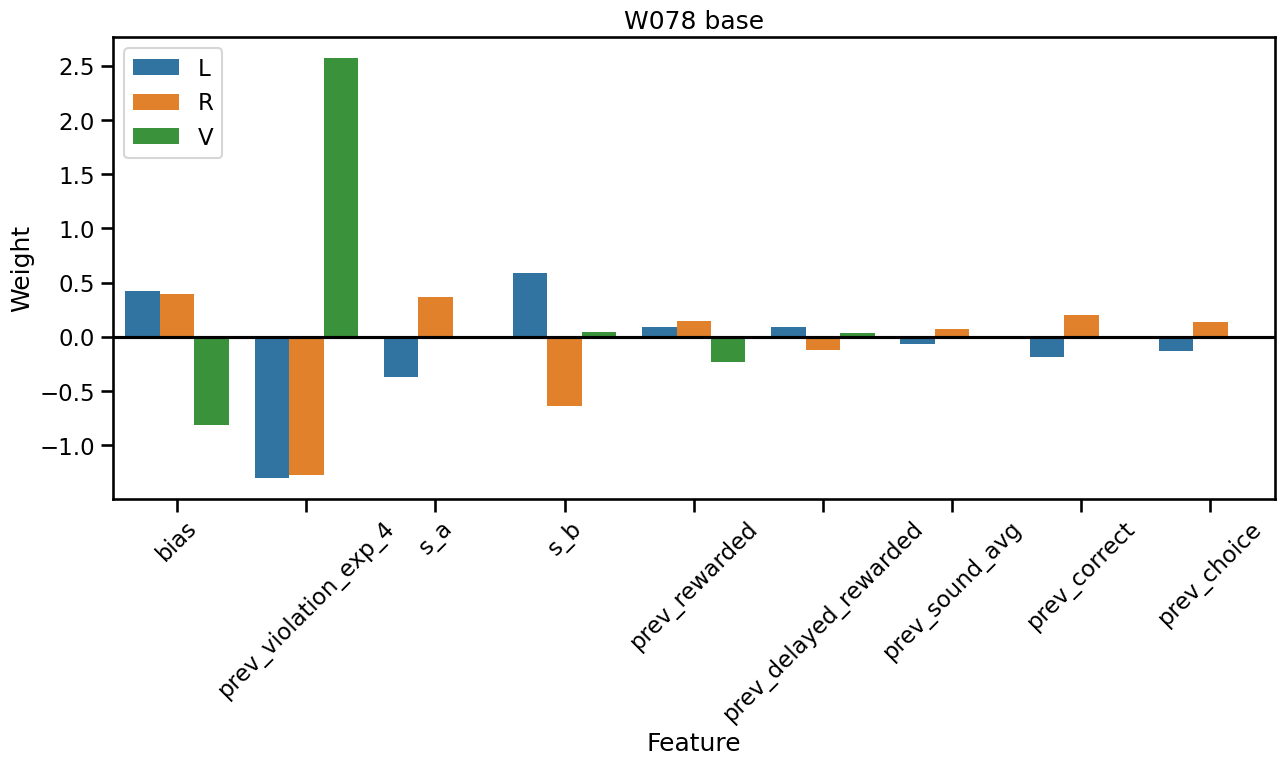

In [316]:
# plot all weights here!
experiment.plot_class_weights(animal_id="W078", model_name="base")

In [264]:
dmg = DesignMatrixGeneratorDelayedReward(verbose=False)
df = get_rat_viol_data(animal_ids="W078").query("training_stage > 2")

returning data for W078


In [245]:
X, Y = dmg.generate_design_matrix(df, tau=0, filter_column="prev_rewarded")
dmg.get_train_test_sessions(df, test_size=0.25, random_state=44)
(
    X_train,
    X_test,
    Y_train,
    Y_test,
) = dmg.apply_session_train_test_split(X, Y)

model = MultiClassLogisticRegression(sigma=None)
W_fit = model.fit(X_train, Y_train)
nll = model.eval(X_test, Y_test)

         Current function value: 25273.319893
         Iterations: 27
         Function evaluations: 72
         Gradient evaluations: 60


In [240]:
X_train.columns

Index(['bias', 'prev_violation_exp_4', 's_a', 's_b', 'prev_sound_avg',
       'prev_correct', 'prev_choice', 'prev_rewarded', 'prev_delayed_reward'],
      dtype='object')

In [191]:
import pandas as pd

# Sample dataframe
pdf = pd.DataFrame(
    {
        "training_stage": [
            1,
            1,
            1,
            2,
            2,
            2,
            2,
            2,
            2,
            3,
            3,
            3,
            3,
            3,
            3,
            3,
            4,
            4,
            4,
            4,
            4,
            4,
        ]
    }
)

pdf["session"] = [
    1,
    2,
    2,
    3,
    3,
    3,
    4,
    4,
    4,
    5,
    5,
    5,
    6,
    6,
    6,
    6,
    7,
    7,
    7,
    8,
    8,
    8,
]

pdf["hit"] = [
    1,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    1,
    1,
    1,
    np.nan,
    np.nan,
    0,
    1,
    1,
    1,
    1,
    0,
    0,
    1,
]
pdf["trial"] = np.arange(len(pdf))

session_boundaries_mask = pdf["session"].diff() == 0

# Shift columns
pdf["prev_hit"] = pdf["hit"].shift(1) * session_boundaries_mask
pdf["prev_training_stage"] = (
    pdf["training_stage"].shift(1) * session_boundaries_mask
).fillna(0)
pdf["error"] = (pdf["hit"] == 0).astype(int)
pdf["prev_error"] = (pdf.error.shift(1) * session_boundaries_mask).fillna(0)

# Initialize the 'prev_delayed_reward' column with zeros


# Apply condition
condition = (pdf["prev_training_stage"] == 3) & (pdf["prev_error"] == 1.0)
pdf.loc[condition, "prev_delayed_reward"] = 1
pdf.fillna(0, inplace=True)  # remove nan from shift()

# Drop the temporary columns if needed
# df.drop(['prev_hit', 'prev_training_stage'], axis=1, inplace=True)
pdf

,training_stage,session,hit,trial,prev_hit,prev_training_stage,error,prev_error,prev_delayed_reward
0,1,1,1.0,0,0.0,0.0,0,0.0,0.0
1,1,2,0.0,1,0.0,0.0,1,0.0,0.0
2,1,2,0.0,2,0.0,1.0,1,1.0,0.0
3,2,3,0.0,3,0.0,0.0,1,0.0,0.0
4,2,3,0.0,4,0.0,2.0,1,1.0,0.0
5,2,3,0.0,5,0.0,2.0,1,1.0,0.0
6,2,4,1.0,6,0.0,0.0,0,0.0,0.0
7,2,4,1.0,7,1.0,2.0,0,0.0,0.0
8,2,4,0.0,8,1.0,2.0,1,0.0,0.0
9,3,5,1.0,9,0.0,0.0,0,0.0,0.0


In [208]:
pdf.columns

Index(['training_stage', 'session', 'hit', 'trial', 'prev_hit',
       'prev_training_stage', 'error', 'prev_error', 'prev_delayed_reward'],
      dtype='object')

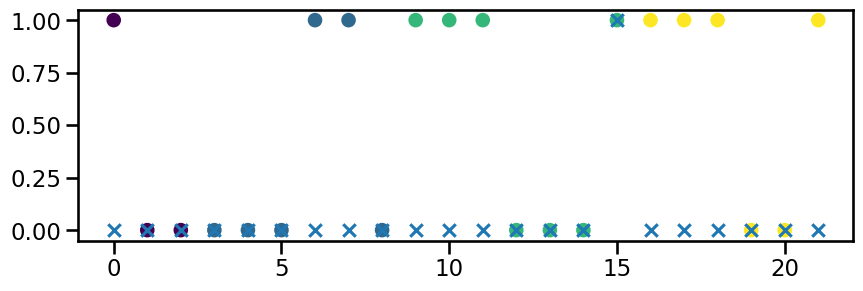

In [213]:
plt.figure(figsize=(10, 3))
plt.scatter(pdf.trial, pdf.hit, c=pdf.training_stage)
plt.scatter(pdf.trial, pdf.prev_delayed_reward, marker="x")

# # Plot black vertical lines for session boundaries
# last_idx_of_each_session = pdf["session"].duplicated(keep="last")
# for idx, is_duplicated in enumerate(last_idx_of_each_session):
#     if not is_duplicated:
#         plt.vlines(
#             x=idx,
#             ymin=0.5,
#             ymax=2,
#             color="k",
#             linestyles="dashed",
#             label="Session boundary",
#         )

In [187]:
pdf["error"] = (pdf["hit"] == 0).astype(int)
pdf["prev_error"] = pdf.error.shift(1)

pdf

,training_stage,session,hit,trial,prev_hit,prev_miss,prev_training_stage,prev_delayed_reward,error,prev_error
0,1,1,1.0,0,NaN,1.0,NaN,0,0,NaN
1,1,2,0.0,1,1.0,0.0,1.0,0,1,0.0
2,1,2,0.0,2,0.0,0.0,1.0,0,1,1.0
3,2,3,0.0,3,0.0,0.0,1.0,0,1,1.0
4,2,3,0.0,4,0.0,0.0,2.0,0,1,1.0
5,2,3,0.0,5,0.0,0.0,2.0,0,1,1.0
6,2,4,1.0,6,0.0,1.0,2.0,0,0,1.0
7,2,4,1.0,7,1.0,1.0,2.0,0,0,0.0
8,2,4,0.0,8,1.0,0.0,2.0,0,1,0.0
9,3,5,1.0,9,0.0,1.0,2.0,0,0,1.0
